# Анализ сегментации городов (1991)

Данные Union Bank о 48 городах; сегменты по экономическим условиям и краткая интерпретация.

**План исследования:**
- первичная проверка и очистка данных;
- обработка пропусков и выбросов;
- разведочный анализ и визуализации;
- сегментация KMeans и иерархическая кластеризация;
- интерпретация кластеров и (опционально) факторный анализ.

In [38]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import FactorAnalysis
from scipy import stats
import scipy.cluster.hierarchy as sch

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 10


## 1. Загрузка и предварительный осмотр данных

In [39]:
data_path = Path("Econom_Cities_data.csv")
df_raw = pd.read_csv(
    data_path,
    sep=";",
    decimal=",",
    na_values=-9999
)

print(f"Размер исходного датасета: {df_raw.shape[0]} наблюдений, {df_raw.shape[1]} показателей")
display(df_raw.head())

Размер исходного датасета: 48 наблюдений, 4 показателей


,City,Work,Price,Salary
0,Amsterdam,1714.0,65.6,49.0
1,Athens,1792.0,53.8,30.4
2,Bogota,2152.0,37.9,11.5
3,Bombay,2052.0,30.3,5.3
4,Brussels,1708.0,73.8,50.5


In [40]:

summary = df_raw.describe().T
missing = df_raw.isna().sum()

display(summary)
display(missing.to_frame(name="missing"))


,count,mean,std,min,25%,50%,75%,max
Work,46.0,1879.913043,174.342552,1583.0,1745.250,1849.00,1976.25,2375.0
Price,48.0,68.860417,21.784659,30.3,49.650,70.50,81.70,115.5
Salary,46.0,39.545652,24.757703,2.7,14.375,43.65,59.70,100.0


,missing
City,0
Work,2
Price,0
Salary,2


## 2. Очистка данных и проверка выбросов

In [41]:
numeric_cols = ["Work", "Price", "Salary"]

missing_cities = df_raw.loc[df_raw[numeric_cols].isna().any(axis=1), "City"].tolist()
df = df_raw.dropna(subset=numeric_cols).reset_index(drop=True)

if missing_cities:
    print(f"Удаляем {len(missing_cities)} города с пропусками: {', '.join(missing_cities)}")
else:
    print("Пропусков в целевых показателях не обнаружено.")

z_scores = np.abs(stats.zscore(df[numeric_cols]))
df["is_outlier"] = (z_scores > 3).any(axis=1)

outlier_cities = df.loc[df["is_outlier"], "City"].tolist()
if outlier_cities:
    print(f"Найдены выбросы: {', '.join(outlier_cities)}")
else:
    print("Выбросы не обнаружены.")

df["outlier_label"] = np.where(df["is_outlier"], "выброс", "норма")
display(df.head())

Удаляем 2 города с пропусками: Cairo, Jakarta
Выбросы не обнаружены.


,City,Work,Price,Salary,is_outlier,outlier_label
0,Amsterdam,1714.0,65.6,49.0,False,норма
1,Athens,1792.0,53.8,30.4,False,норма
2,Bogota,2152.0,37.9,11.5,False,норма
3,Bombay,2052.0,30.3,5.3,False,норма
4,Brussels,1708.0,73.8,50.5,False,норма


In [42]:
df_model = df.loc[~df["is_outlier"]].copy()
df_model = df_model.drop(columns=["is_outlier"]).reset_index(drop=True)

print(f"Датасет для кластеризации: {df_model.shape[0]} городов")
display(df_model.head())

Датасет для кластеризации: 46 городов


,City,Work,Price,Salary,outlier_label
0,Amsterdam,1714.0,65.6,49.0,норма
1,Athens,1792.0,53.8,30.4,норма
2,Bogota,2152.0,37.9,11.5,норма
3,Bombay,2052.0,30.3,5.3,норма
4,Brussels,1708.0,73.8,50.5,норма


### Разведочный анализ

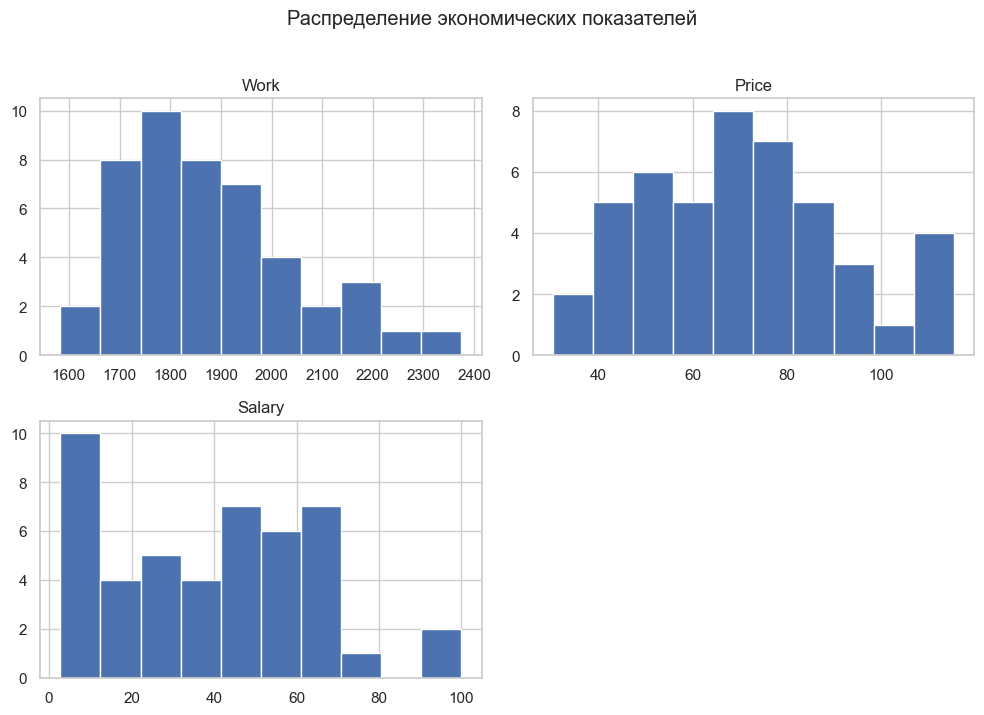

In [43]:
axes = df_model[numeric_cols].hist(figsize=(10, 7), bins=10)
plt.suptitle("Распределение экономических показателей", y=1.02)
plt.tight_layout()

Text(0.5, 1.02, 'Парные отношения показателей')

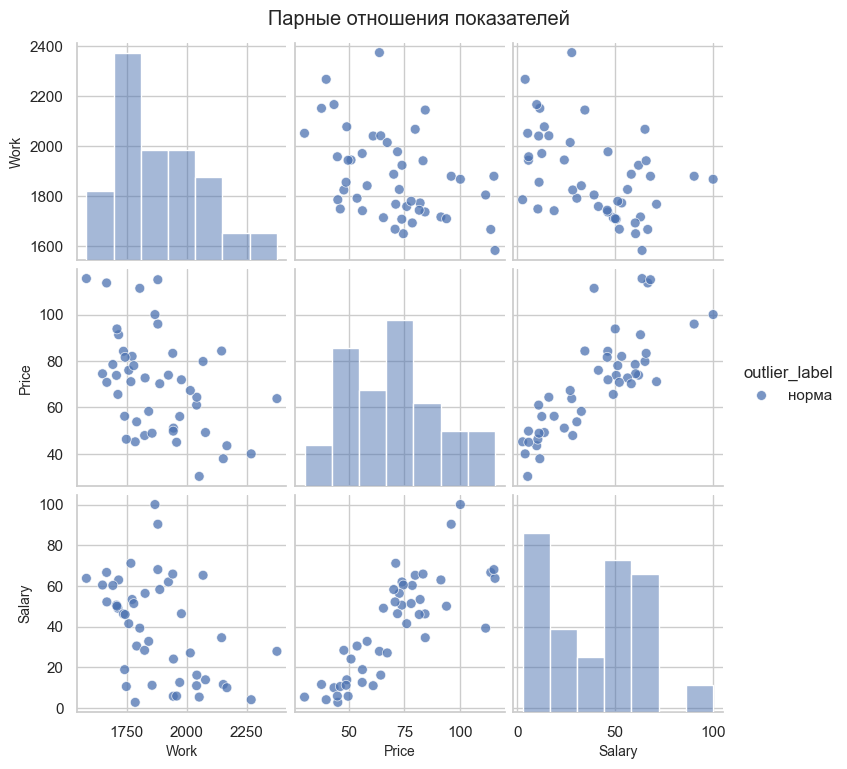

In [44]:
pairplot_data = df.copy()
sns.pairplot(
    data=pairplot_data,
    vars=numeric_cols,
    hue="outlier_label",
    diag_kind="hist",
    plot_kws={"alpha": 0.75, "s": 50}
)
plt.suptitle("Парные отношения показателей", y=1.02)

In [45]:
df_model = df_model.drop(columns=["outlier_label"], errors="ignore")

## 3. Стандартизация и выбор числа кластеров

In [46]:
features = numeric_cols.copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model[features])

print("Пример стандартизированных значений:")
display(pd.DataFrame(X_scaled[:5], columns=[f"z_{col}" for col in features]))

Пример стандартизированных значений:


,z_Work,z_Price,z_Salary
0,-0.962166,-0.212712,0.386095
1,-0.509827,-0.770489,-0.373488
2,1.577891,-1.522069,-1.145323
3,0.997969,-1.881316,-1.398517
4,-0.996961,0.174896,0.447351


In [47]:
k_values = range(2, 7)
metrics = []

for k in k_values:
    model = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = model.fit_predict(X_scaled)
    inertia = model.inertia_
    silhouette = silhouette_score(X_scaled, labels)
    metrics.append({"k": k, "inertia": inertia, "silhouette": silhouette})

metrics_df = pd.DataFrame(metrics)
display(metrics_df)

best_k_silhouette = metrics_df.loc[metrics_df["silhouette"].idxmax(), "k"]
print(f"Максимальное значение силуэта достигается при k = {best_k_silhouette:.0f}")

,k,inertia,silhouette
0,2,61.116633,0.470499
1,3,47.361048,0.387546
2,4,35.552814,0.365753
3,5,27.763282,0.375028
4,6,23.212681,0.373039


Максимальное значение силуэта достигается при k = 2


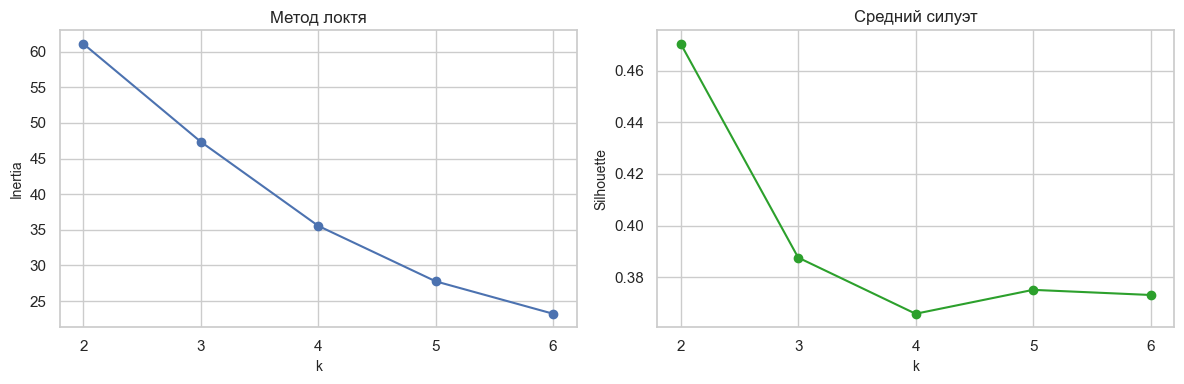

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(metrics_df["k"], metrics_df["inertia"], marker="o")
axes[0].set_title("Метод локтя")
axes[0].set_xlabel("k")
axes[0].set_ylabel("Inertia")

axes[1].plot(metrics_df["k"], metrics_df["silhouette"], marker="o", color="tab:green")
axes[1].set_title("Средний силуэт")
axes[1].set_xlabel("k")
axes[1].set_ylabel("Silhouette")

for ax in axes:
    ax.set_xticks(list(k_values))

plt.tight_layout()

## 4. KMeans-кластеризация и интерпретация

In [49]:
optimal_k = 3
print(
    "Используем k = {0} для финальной модели (учитывая баланс между силуэтом, методом локтя и бизнес-логикой).".format(optimal_k)
)

kmeans = KMeans(n_clusters=optimal_k, n_init=20, random_state=42)
df_model["kmeans_cluster"] = kmeans.fit_predict(X_scaled)

cluster_centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=features
).round(1)
cluster_centers.index.name = "kmeans_cluster"
display(cluster_centers)

Используем k = 3 для финальной модели (учитывая баланс между силуэтом, методом локтя и бизнес-логикой).


,Work,Price,Salary
kmeans_cluster,,,
0,1855.5,50.8,16.6
1,1789.2,85.0,59.0
2,2133.5,54.2,16.1


In [50]:

cluster_counts = df_model["kmeans_cluster"].value_counts().sort_index()
cluster_profile = df_model.groupby("kmeans_cluster")[features].mean().round(1)
cluster_profile["cities_count"] = cluster_counts
cluster_profile["examples"] = (
    df_model.groupby("kmeans_cluster")["City"].apply(lambda s: ", ".join(s.sort_values().head(3)))
)
cluster_profile = cluster_profile.sort_values("Price")
display(cluster_profile)


,Work,Price,Salary,cities_count,examples
kmeans_cluster,,,,,
0,1855.5,50.8,16.6,11,"Athens, Buenos_Aires, Johannesburg"
2,2133.5,54.2,16.1,10,"Bogota, Bombay, Caracas"
1,1789.2,85.0,59.0,25,"Amsterdam, Brussels, Chicago"


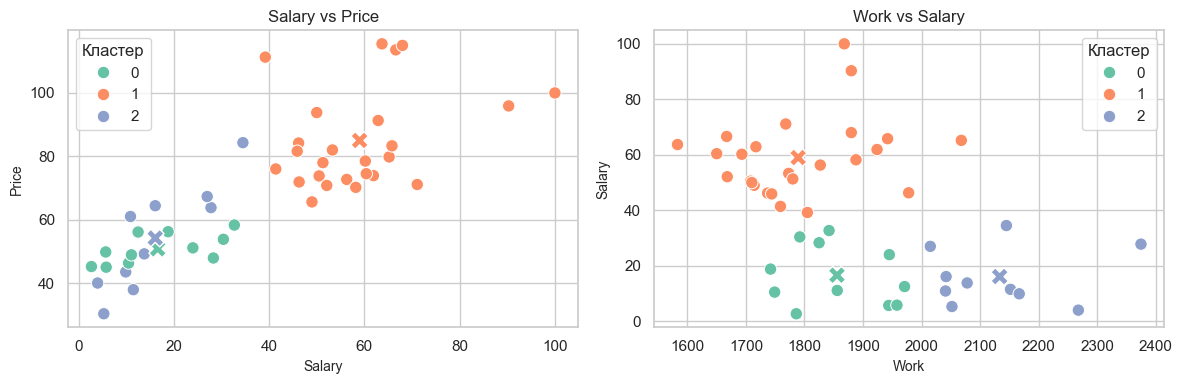

In [51]:
centers_plot = cluster_centers.copy()
centers_plot = centers_plot.reset_index().rename(columns={"kmeans_cluster": "cluster"})

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.scatterplot(
    data=df_model,
    x="Salary",
    y="Price",
    hue="kmeans_cluster",
    palette="Set2",
    s=80,
    ax=axes[0]
)
sns.scatterplot(
    data=centers_plot,
    x="Salary",
    y="Price",
    hue="cluster",
    palette="Set2",
    s=160,
    marker="X",
    ax=axes[0],
    legend=False
)
axes[0].set_title("Salary vs Price")

sns.scatterplot(
    data=df_model,
    x="Work",
    y="Salary",
    hue="kmeans_cluster",
    palette="Set2",
    s=80,
    ax=axes[1]
)
sns.scatterplot(
    data=centers_plot,
    x="Work",
    y="Salary",
    hue="cluster",
    palette="Set2",
    s=160,
    marker="X",
    ax=axes[1],
    legend=False
)
axes[1].set_title("Work vs Salary")

for ax in axes:
    ax.legend(title="Кластер")

plt.tight_layout()

**Интерпретация KMeans-сегментов:**
- `kmeans_cluster = 1`: города с высокими ценами и зарплатами (Zurich, Tokyo, Geneva, Oslo). Жители работают относительно меньше часов, но получают больше среднего.
- `kmeans_cluster = 0`: города со средним уровнем цен и умеренными зарплатами; много европейских и латиноамериканских локаций (Athens, Lisbon, Mexico City).
- `kmeans_cluster = 2`: города с длинным рабочим днём и невысокими зарплатами, в основном Азия и Латинская Америка (Bogota, Manila, Hong Kong).

## 5. Иерархическая кластеризация (Ward)

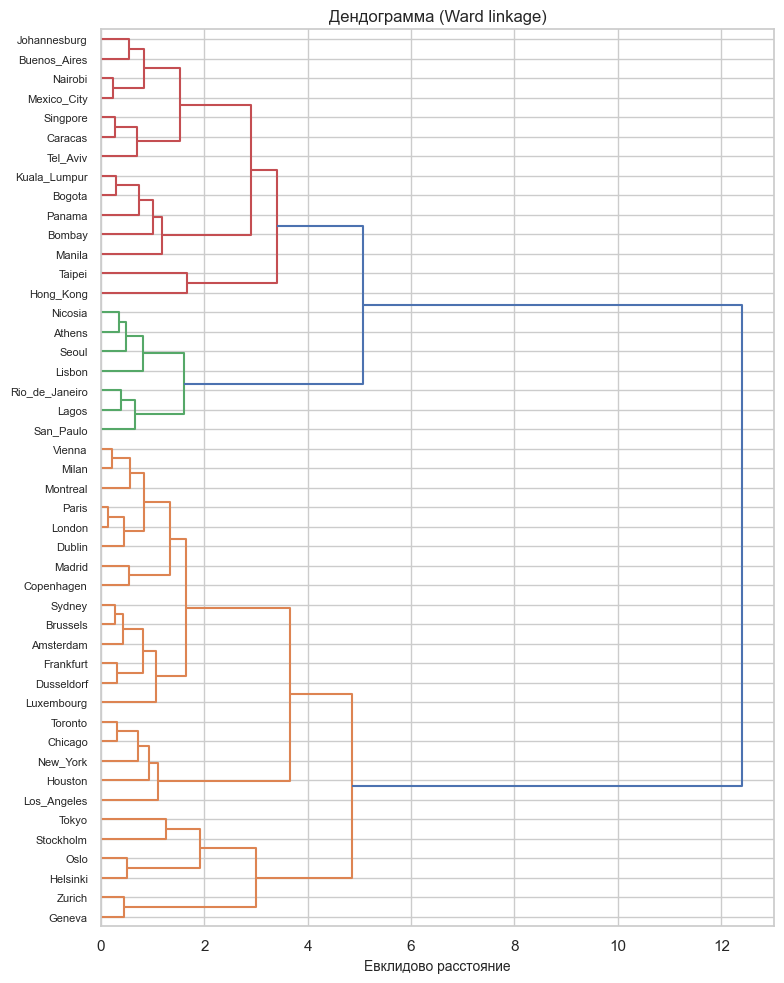

In [52]:
linkage_matrix = sch.linkage(X_scaled, method="ward")
color_threshold = linkage_matrix[-(optimal_k - 1), 2]

plt.figure(figsize=(8, 10))
sch.dendrogram(
    linkage_matrix,
    labels=df_model["City"].values,
    orientation="right",
    color_threshold=color_threshold
)
plt.title("Дендограмма (Ward linkage)")
plt.xlabel("Евклидово расстояние")
plt.tight_layout()

In [53]:

agg = AgglomerativeClustering(n_clusters=optimal_k, linkage="ward")
df_model["hier_cluster"] = agg.fit_predict(X_scaled)

cross_tab = pd.crosstab(df_model["kmeans_cluster"], df_model["hier_cluster"])
display(cross_tab)

hier_profile = df_model.groupby("hier_cluster")[features].mean().round(1)
display(hier_profile)


hier_cluster,0,1,2
kmeans_cluster,,,
0,0,4,7
1,25,0,0
2,0,10,0


,Work,Price,Salary
hier_cluster,,,
0,1789.2,85.0,59.0
1,2082.4,53.1,14.9
2,1798.9,50.9,19.2


**Наблюдения по иерархической модели:** иерархическая кластеризация даёт схожее разбиение: один кластер с высокими ценами/зарплатами, два — с более доступной стоимостью жизни; Ward-алгоритм группирует часть городов с высокой нагрузкой по часам, что кажется дополнительно полезно.

## 6. Дополнительно: факторный анализ

,Work,Price,Salary
Factor 1,-0.51,0.89,0.90
Factor 2,0.23,0.03,0.01


,Factor 1,Factor 2,City,kmeans_cluster
0,0.161083,-0.301194,Amsterdam,1
1,-0.503297,-0.271133,Athens,0
2,-1.394532,0.237597,Bogota,2
3,-1.640111,0.001665,Bombay,2
4,0.376472,-0.261201,Brussels,1


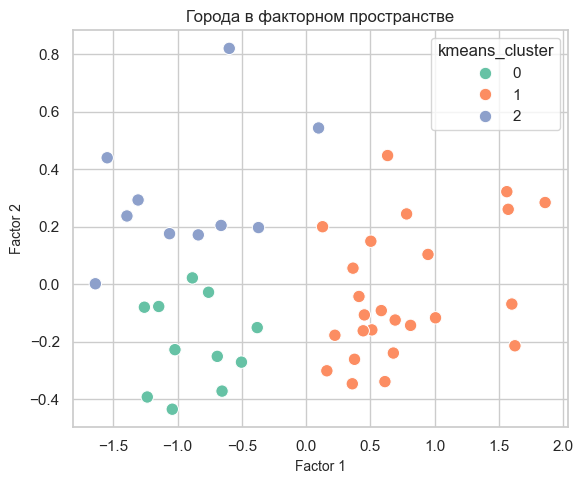

In [54]:
fa = FactorAnalysis(n_components=2, random_state=42)
factor_scores = fa.fit_transform(X_scaled)

loadings = pd.DataFrame(
    fa.components_,
    columns=features,
    index=["Factor 1", "Factor 2"]
).round(2)
display(loadings)

factor_df = pd.DataFrame(factor_scores, columns=["Factor 1", "Factor 2"])
factor_df["City"] = df_model["City"].values
factor_df["kmeans_cluster"] = df_model["kmeans_cluster"].values

display(factor_df.head())

plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=factor_df,
    x="Factor 1",
    y="Factor 2",
    hue="kmeans_cluster",
    palette="Set2",
    s=80
)
plt.title("Города в факторном пространстве")
plt.tight_layout()

In [55]:
X_scaled

array([[-9.62165519e-01, -2.12711564e-01,  3.86094737e-01],
       [-5.09826698e-01, -7.70488553e-01, -3.73488287e-01],
       [ 1.57789094e+00, -1.52206941e+00, -1.14532265e+00],
       [ 9.97969372e-01, -1.88131561e+00, -1.39851699e+00],
       [-9.96960813e-01,  1.74896175e-01,  4.47351433e-01],
       [ 5.28232904e-01, -6.61769309e-01, -1.10448485e+00],
       [ 9.34178000e-01, -4.30150051e-01, -1.16982533e+00],
       [ 2.55669768e-01,  1.79623098e-01,  9.12902319e-01],
       [-9.44767872e-01,  1.00210781e+00,  9.53740116e-01],
       [-7.01200814e-01,  2.78888495e-01,  7.57274801e-02],
       [-1.08394905e+00,  3.97061586e-01,  8.43478064e-01],
       [-1.33331532e+00,  2.07984640e-01,  8.51645623e-01],
       [ 5.04279622e-04,  1.21954630e+00,  2.07269575e+00],
       [-1.23472865e+00,  2.05621178e+00,  1.10483996e+00],
       [ 2.87111603e+00, -2.97796189e-01, -4.79666559e-01],
       [ 5.68827414e-01,  8.50846255e-02,  2.75832685e-01],
       [ 3.77453297e-01, -8.98115491e-01

## 7 Кластеризация методом DBSCAN

**DBSCAN (Density-Based Spatial Clustering of Applications with Noise)** — это алгоритм кластеризации, основанный на плотности точек.
Он выделяет области высокой плотности (кластеры) и отделяет шум.

Основные параметры:
- `eps` — радиус окрестности точки (максимальное расстояние между точками в одном кластере)
- `min_samples` — минимальное число соседей в окрестности, чтобы считать точку “ядром кластера”
- Алгоритм не требует заранее задавать число кластеров!


In [56]:
from sklearn.cluster import DBSCAN

# Создаём и обучаем модель
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(X_scaled)

# Смотрим базовую информацию
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"Количество кластеров: {n_clusters}")
print(f"Количество шумовых точек: {n_noise}")

Количество кластеров: 1
Количество шумовых точек: 36


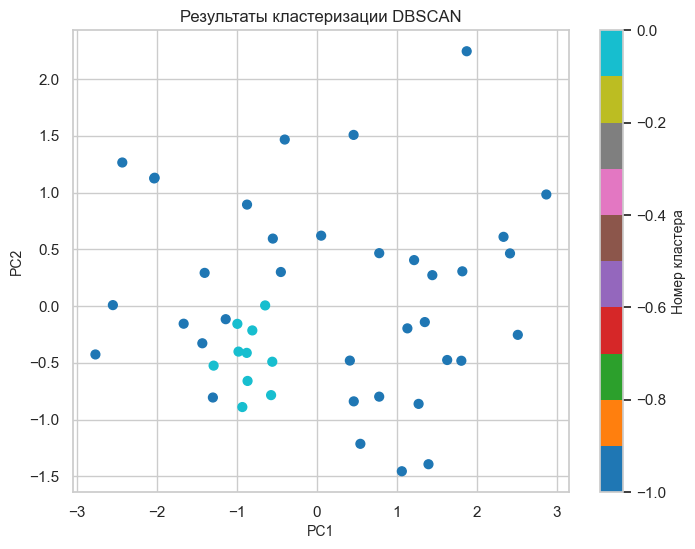

In [58]:
# Уменьшим размерность для визуализации
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='tab10', s=40)
plt.title("Результаты кластеризации DBSCAN")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Номер кластера")
plt.show()


In [65]:
eps_values = [0.5, 0.8, 1.0]
min_samples_values = [2, 4, 9]

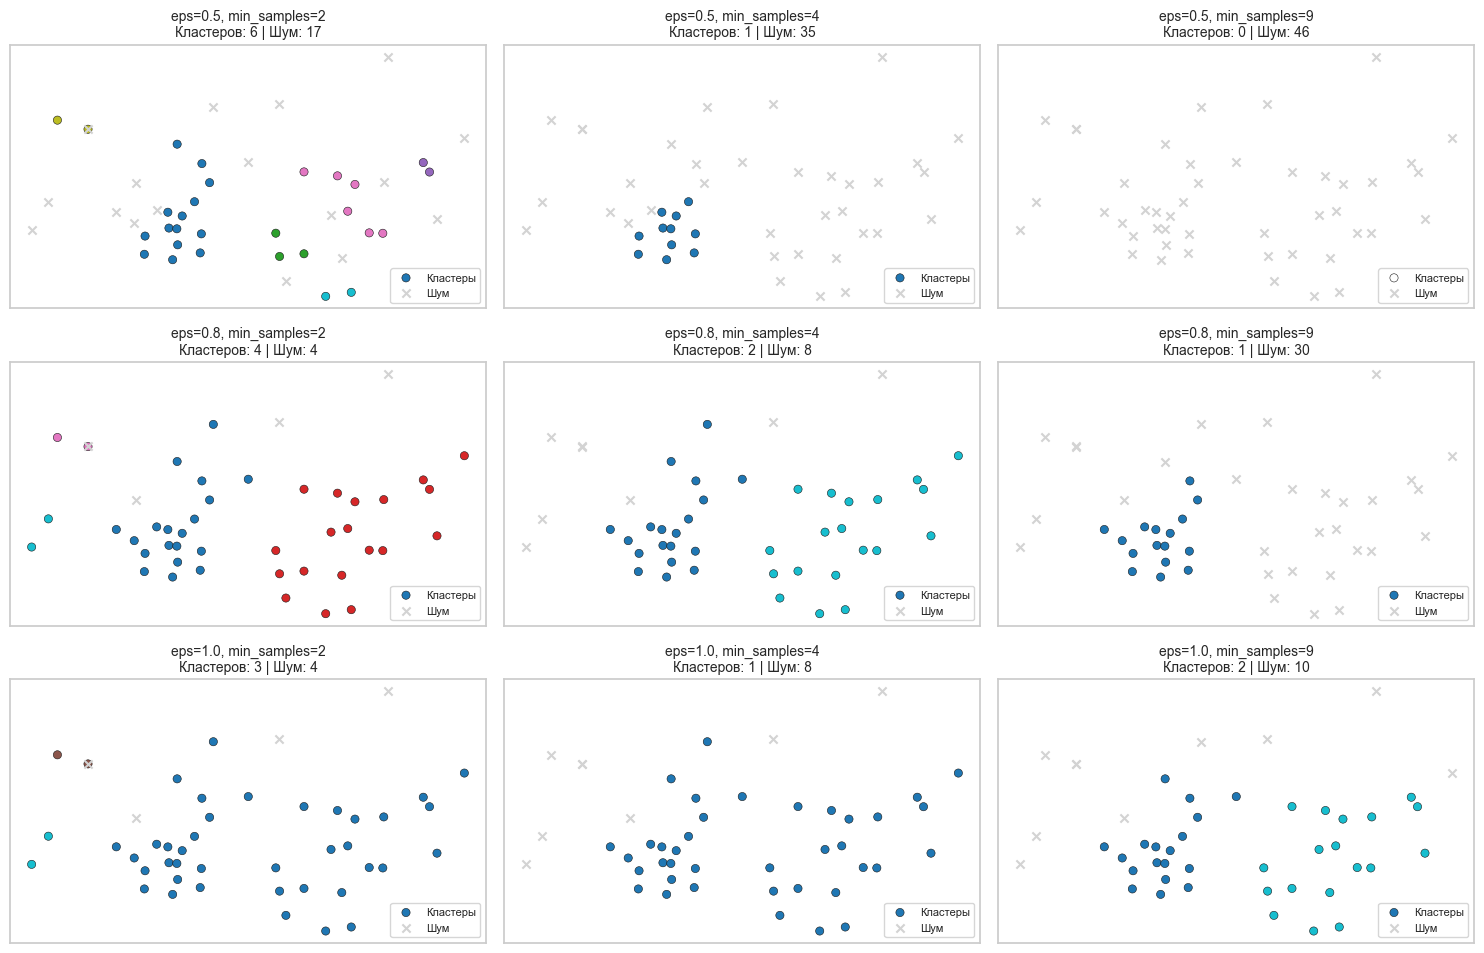

In [66]:
fig, axes = plt.subplots(len(eps_values), len(min_samples_values), figsize=(15, 10))

for i, eps in enumerate(eps_values):
    for j, min_s in enumerate(min_samples_values):
        model = DBSCAN(eps=eps, min_samples=min_s)
        labels = model.fit_predict(X_scaled)
        ax = axes[i, j]

        # Маска для выбросов
        core_mask = labels != -1
        noise_mask = labels == -1

        # Кластеры
        scatter = ax.scatter(
            X_pca[core_mask, 0], X_pca[core_mask, 1],
            c=labels[core_mask],
            cmap='tab10',
            s=35,
            edgecolor='k',
            linewidth=0.4,
            label='Кластеры'
        )

        # Шум (outliers)
        ax.scatter(
            X_pca[noise_mask, 0], X_pca[noise_mask, 1],
            c='lightgray',
            s=35,
            marker='x',
            label='Шум'
        )

        ax.set_title(f"eps={eps}, min_samples={min_s}\n"
                     f"Кластеров: {len(set(labels)) - (1 if -1 in labels else 0)} | "
                     f"Шум: {np.sum(noise_mask)}",
                     fontsize=10)
        ax.set_xticks([]); ax.set_yticks([])
        ax.legend(loc='lower right', fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


- **Точки с меткой -1** — это шум (outliers), не принадлежащий ни одному кластеру.
- При **малых eps** DBSCAN находит больше мелких кластеров, но и шумовых точек становится больше.
- При **больших eps** кластеры сливаются — можно потерять структуру данных.
- **min_samples** регулирует, насколько плотными должны быть кластеры:
  чем больше это значение, тем труднее образовать кластер.

**Преимущества DBSCAN:**
- Не требует задавать количество кластеров заранее.
- Устойчив к выбросам и может выявлять кластеры произвольной формы.

**Недостатки:**
- Чувствителен к выбору `eps` и `min_samples`.
- Плохо работает на данных с переменной плотностью (один `eps` не подходит всем кластерам).
